<a href="https://colab.research.google.com/github/BrunoBreggia/Flow-Matching/blob/main/Flow_Matching_Bruno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejemplo copiado del Codigo 1 de Flow Matching de Meta (pag 7)

In [ ]:
# 1) Defino la red (el Flujo)

import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

class Flow(nn.Module):
  def __init__(self, dim: int = 2, h: int = 64):
    super().__init__()
    self.net = nn.Sequential(
    nn.Linear(dim + 1, h), nn.ELU(),
    nn.Linear(h, h), nn.ELU(),
    nn.Linear(h, h), nn.ELU(),
    nn.Linear(h, dim))

  def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
    return self.net(torch.cat((t, x_t), -1))

  def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
    # este metodo se usa a la hora de evaluar el metodo, no en el entrenamiento
    t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
    # Metodo de resolucion de ODE (utiliza el metodo del punto medio)
    return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end - t_start) / 2,
    t_start + (t_end - t_start) / 2)

In [ ]:
# 2) Entrenamiento
flow = Flow()
optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
  x_1 = Tensor(make_moons(256, noise=0.05)[0])  # generate sample data -> target distribution
  x_0 = torch.randn_like(x_1)  # sample from initial distribution
  t = torch.rand(len(x_1), 1)
  x_t = (1 - t) * x_0 + t * x_1
  dx_t = x_1 - x_0
  optimizer.zero_grad()
  loss_fn(flow(x_t, t), dx_t).backward()
  optimizer.step()

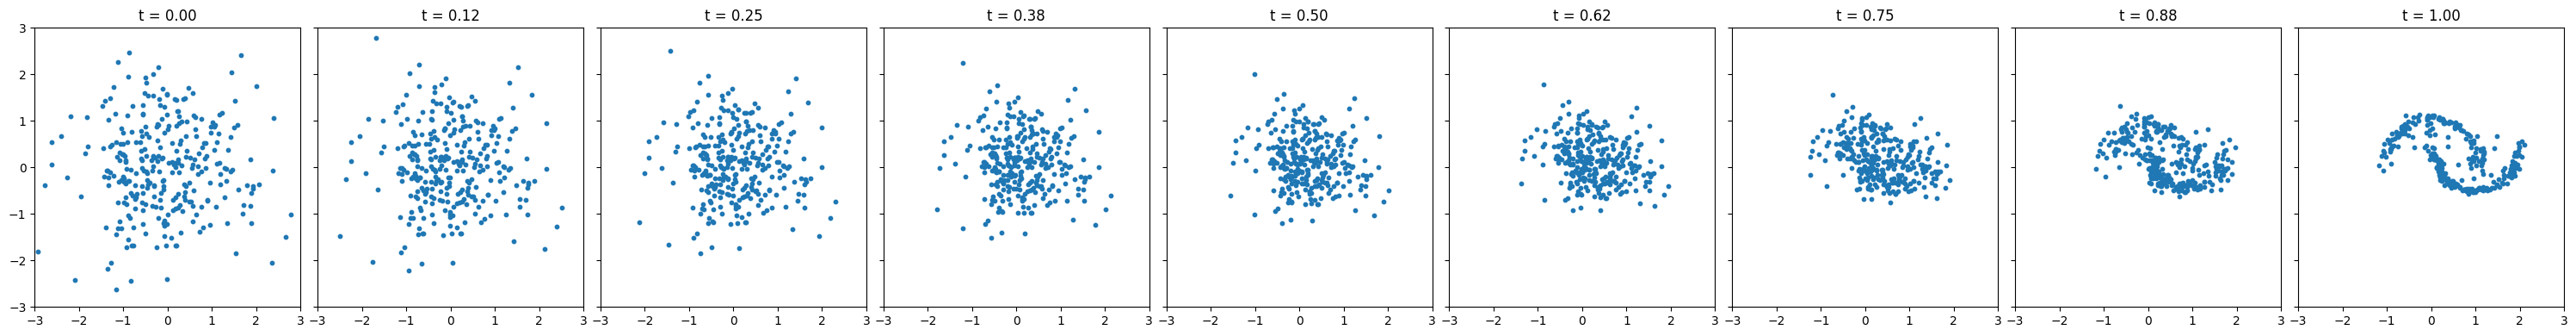

In [ ]:
# Muestreo
x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
  x = flow.step(x, time_steps[i], time_steps[i + 1])
  axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
  axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

Genero una nueva distribucion de datos no gaussiana

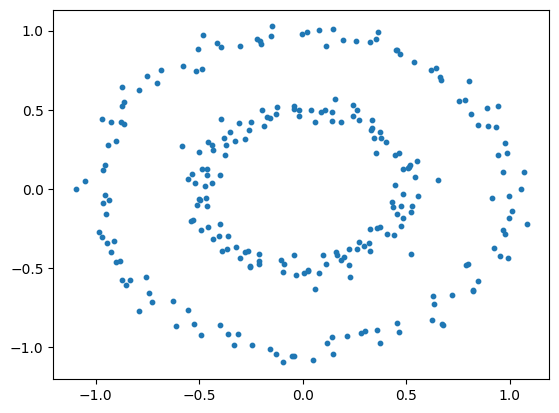

In [ ]:
from sklearn.datasets import make_circles

noisy_circles = make_circles(n_samples=256, factor=0.5, noise=0.05)[0]
plt.scatter(noisy_circles[:, 0], noisy_circles[:, 1], s=10)
plt.show()
# print(noisy_circles)

Pruebo a ver si el modelo entrenado con datos de entrada gaussianos me sirve para esta distribucion

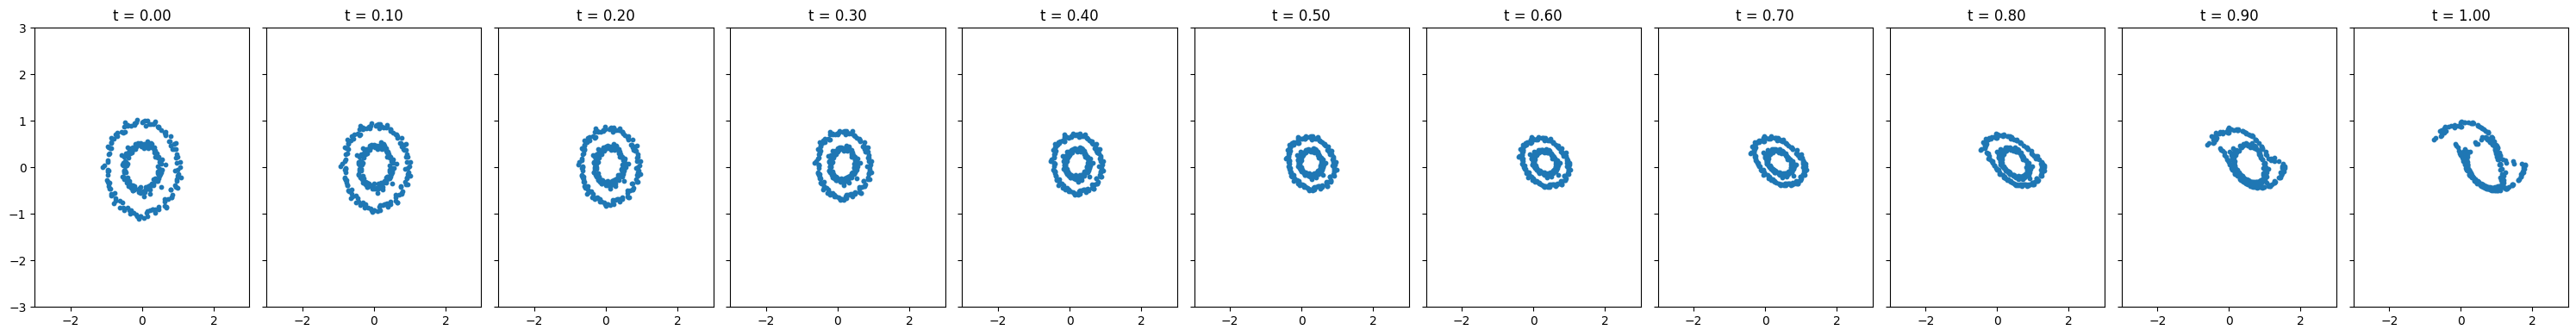

In [ ]:
# 3) Muestreo
x = Tensor(noisy_circles)
n_steps = 10
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
  x = flow.step(x, time_steps[i], time_steps[i + 1])
  axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
  axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

Entreno otro modelo de cero pero con esta nueva distribucion como entrada

In [ ]:
# repito 2) Entreno con datos de distribucion circular
flow = Flow()
optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

# Usamos linear probability path (transporte optimo)
for _ in range(10000):
  x_1 = Tensor(make_moons(256, noise=0.05)[0])  # generate sample data -> target distribution
  x_0 = Tensor(make_circles(n_samples=256, factor=0.5, noise=0.05)[0])  # sample from initial distribution
  t = torch.rand(len(x_1), 1)
  x_t = (1 - t) * x_0 + t * x_1  # p_t(x|x_1): conditional probability path
  dx_t = x_1 - x_0  # conditional vector field
  optimizer.zero_grad()
  loss_fn(flow(x_t, t), dx_t).backward()
  optimizer.step()

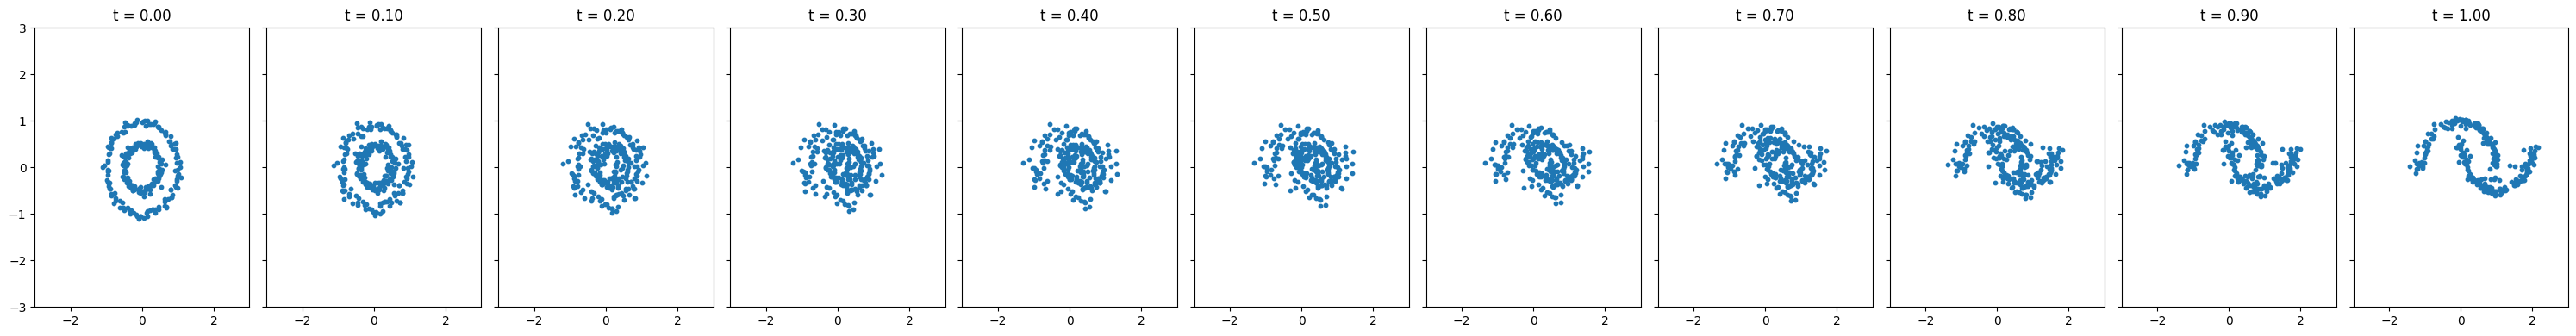

In [ ]:
# 3) Muestreo
x = Tensor(noisy_circles)
n_steps = 10
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
  x = flow.step(x, time_steps[i], time_steps[i + 1])
  axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
  axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

#Aplicado a la Ecuacion de Onda

Epoch 1, Loss: 386.3673
Epoch 2, Loss: 266.0644
Epoch 3, Loss: 238.7465
Epoch 4, Loss: 219.4105
Epoch 5, Loss: 195.1681
Epoch 6, Loss: 177.9399
Epoch 7, Loss: 165.9845
Epoch 8, Loss: 158.1104
Epoch 9, Loss: 151.7952
Epoch 10, Loss: 148.1484


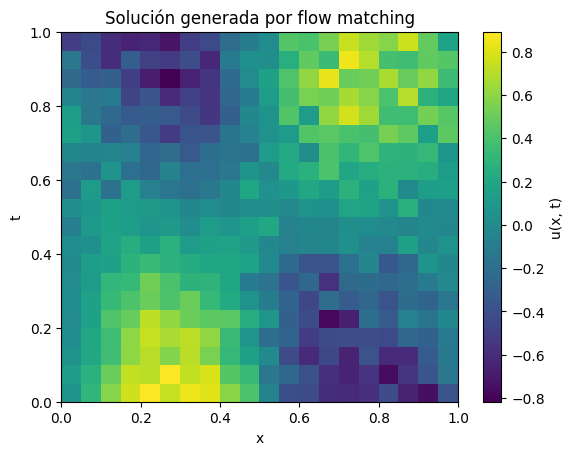

In [ ]:
# wave_equation_flowmatch.py (versión acelerada)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del dominio
L = 1.0       # Longitud del dominio espacial
T = 1.0       # Tiempo total
Nx = 20       # Menor cantidad de puntos espaciales
Nt = 20       # Menor cantidad de pasos de tiempo
c = 0.5       # Velocidad de la onda (ajustada para estabilidad)

x_global = np.linspace(0, L, Nx)
t_global = np.linspace(0, T, Nt)
dx = x_global[1] - x_global[0]
dt = t_global[1] - t_global[0]

assert c * dt / dx <= 1.0, "Violación de la condición CFL"

# Función para generar soluciones numéricas de la ecuación de onda

def solve_wave_eq(u0, v0, c, dx, dt, Nx, Nt):
    u = np.zeros((Nt, Nx))
    u[0, :] = u0
    u[1, 1:-1] = u0[1:-1] + dt * v0[1:-1] + 0.5 * (c * dt / dx)**2 * (u0[2:] - 2*u0[1:-1] + u0[:-2])

    for n in range(1, Nt - 1):
        u[n + 1, 1:-1] = 2 * u[n, 1:-1] - u[n - 1, 1:-1] + (c * dt / dx)**2 * (u[n, 2:] - 2 * u[n, 1:-1] + u[n, :-2])
    return u

# Red neuronal más pequeña
class VelocityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, t, s, u_s):
        inp = torch.cat([x, t, s, u_s], dim=-1)
        return self.net(inp)

# Dataset sintético
class WaveDataset(torch.utils.data.Dataset):
    def __init__(self, N_samples=50):
        self.samples = []
        for _ in range(N_samples):
            u0 = np.sin(2 * np.pi * np.linspace(0, L, Nx)) * np.random.uniform(0.5, 1.0)
            v0 = np.zeros_like(u0)
            u = solve_wave_eq(u0, v0, c, dx, dt, Nx, Nt)

            xi = np.random.randn(*u.shape)
            s = np.random.rand()
            u_s = (1 - s) * xi + s * u
            v = u - xi

            for i in range(Nt):
                for j in range(Nx):
                    self.samples.append((x_global[j], t_global[i], s, u_s[i, j], v[i, j]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, t_, s, u_s, v = self.samples[idx]
        return (
            torch.tensor([x], dtype=torch.float32),
            torch.tensor([t_], dtype=torch.float32),
            torch.tensor([s], dtype=torch.float32),
            torch.tensor([u_s], dtype=torch.float32),
            torch.tensor([v], dtype=torch.float32),
        )

# Entrenamiento
model = VelocityNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = torch.utils.data.DataLoader(WaveDataset(), batch_size=32, shuffle=True)

for epoch in range(10):
    total_loss = 0
    for x, t_, s, u_s, v_target in dataloader:
        x = x.view(-1, 1)
        t_ = t_.view(-1, 1)
        s = s.view(-1, 1)
        u_s = u_s.view(-1, 1)
        v_target = v_target.view(-1, 1)

        pred = model(x, t_, s, u_s)
        loss = F.mse_loss(pred, v_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Ejemplo de generación (sampling)
xv, tv = np.meshgrid(x_global, t_global)
xv = torch.tensor(xv.flatten(), dtype=torch.float32).unsqueeze(-1)
tv = torch.tensor(tv.flatten(), dtype=torch.float32).unsqueeze(-1)
s = torch.zeros_like(xv)
u_s = torch.randn_like(xv)

n_steps = 10
for i in range(n_steps):
    s_val = (i + 1) / n_steps
    s.fill_(float(s_val))
    with torch.no_grad():
        v_pred = model(xv, tv, s, u_s)
    u_s += v_pred / n_steps

u_generated = u_s.view(Nt, Nx).numpy()

plt.imshow(u_generated, extent=[0, L, 0, T], aspect='auto', origin='lower')
plt.title("Solución generada por flow matching")
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar(label="u(x, t)")
plt.show()


Con visualizacion de pasos intermedios

Epoch 1, Loss: 402.5012
Epoch 2, Loss: 280.0448
Epoch 3, Loss: 247.2550
Epoch 4, Loss: 223.8046
Epoch 5, Loss: 203.4351
Epoch 6, Loss: 189.0419
Epoch 7, Loss: 175.6506
Epoch 8, Loss: 162.0939
Epoch 9, Loss: 153.4746
Epoch 10, Loss: 147.0104


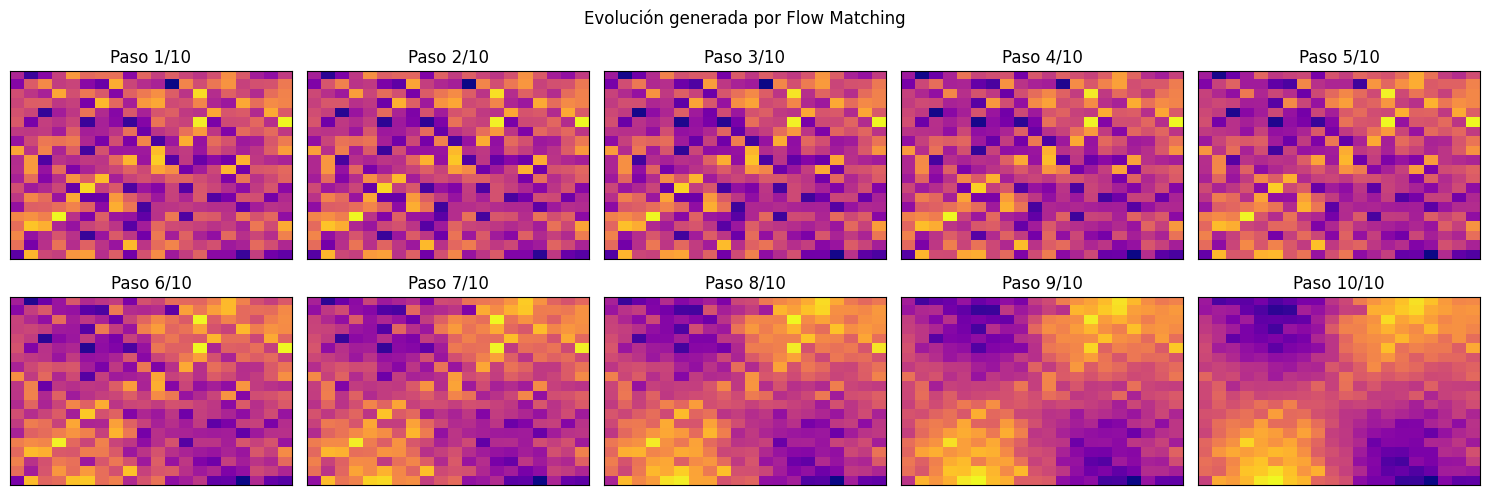

In [ ]:
# wave_equation_flowmatch.py (versión acelerada)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del dominio
L = 1.0       # Longitud del dominio espacial
T = 1.0       # Tiempo total
Nx = 20       # Menor cantidad de puntos espaciales
Nt = 20       # Menor cantidad de pasos de tiempo
c = 0.5       # Velocidad de la onda (ajustada para estabilidad)

xg = np.linspace(0, L, Nx)
tg = np.linspace(0, T, Nt)
dx = xg[1] - xg[0]
dt = tg[1] - tg[0]

assert c * dt / dx <= 1.0, "Violación de la condición CFL"

# Función para generar soluciones numéricas de la ecuación de onda

def solve_wave_eq(u0, v0, c, dx, dt, Nx, Nt):
    u = np.zeros((Nt, Nx))
    u[0, :] = u0
    u[1, 1:-1] = u0[1:-1] + dt * v0[1:-1] + 0.5 * (c * dt / dx)**2 * (u0[2:] - 2*u0[1:-1] + u0[:-2])

    for n in range(1, Nt - 1):
        u[n + 1, 1:-1] = 2 * u[n, 1:-1] - u[n - 1, 1:-1] + (c * dt / dx)**2 * (u[n, 2:] - 2 * u[n, 1:-1] + u[n, :-2])
    return u

# Red neuronal más pequeña
class VelocityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, t, s, u_s):
        inp = torch.cat([x, t, s, u_s], dim=-1)
        return self.net(inp)

# Dataset sintético
class WaveDataset(torch.utils.data.Dataset):
    def __init__(self, N_samples=50):
        self.samples = []
        self.example_start = None
        self.example_end = None
        for _ in range(N_samples):
            u0 = np.sin(2 * np.pi * np.linspace(0, L, Nx)) * np.random.uniform(0.5, 1.0)
            v0 = np.zeros_like(u0)
            u = solve_wave_eq(u0, v0, c, dx, dt, Nx, Nt)

            xi = np.random.randn(*u.shape)
            s = np.random.rand()
            u_s = (1 - s) * xi + s * u
            v = u - xi

            if self.example_start is None:
                self.example_start = xi.copy()
                self.example_end = u.copy()

            for i in range(Nt):
                for j in range(Nx):
                    self.samples.append((xg[j], tg[i], s, u_s[i, j], v[i, j]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, t_, s, u_s, v = self.samples[idx]
        return (
            torch.tensor([x], dtype=torch.float32),
            torch.tensor([t_], dtype=torch.float32),
            torch.tensor([s], dtype=torch.float32),
            torch.tensor([u_s], dtype=torch.float32),
            torch.tensor([v], dtype=torch.float32),
        )

# Entrenamiento
model = VelocityNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataset = WaveDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(10):
    total_loss = 0
    for x, t_, s, u_s, v_target in dataloader:
        x = x.view(-1, 1)
        t_ = t_.view(-1, 1)
        s = s.view(-1, 1)
        u_s = u_s.view(-1, 1)
        v_target = v_target.view(-1, 1)

        pred = model(x, t_, s, u_s)
        loss = F.mse_loss(pred, v_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Ejemplo de generación (sampling con pasos intermedios)
xv, tv = np.meshgrid(xg, tg)
xv = torch.tensor(xv.flatten(), dtype=torch.float32).unsqueeze(-1)
tv = torch.tensor(tv.flatten(), dtype=torch.float32).unsqueeze(-1)
s = torch.zeros_like(xv)
u_s = torch.randn_like(xv)

n_steps = 10
intermediate_states = []
for i in range(n_steps):
    s_val = (i + 1) / n_steps
    s.fill_(float(s_val))
    with torch.no_grad():
        v_pred = model(xv, tv, s, u_s)
    u_s += v_pred / n_steps
    intermediate_states.append(u_s.clone().squeeze(-1).view(Nt, Nx).numpy())

# Mostrar pasos intermedios
fig, axs = plt.subplots(2, n_steps // 2, figsize=(15, 5))
axs = axs.flatten()
for i, state in enumerate(intermediate_states):
    axs[i].imshow(state, extent=[0, L, 0, T], aspect='auto', origin='lower', cmap='plasma')
    axs[i].set_title(f"Paso {i+1}/{n_steps}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.suptitle("Evolución generada por Flow Matching")
plt.tight_layout()
plt.show()



In [ ]:
# guardar como gif
import imageio
import os

# Crear una carpeta temporal para guardar los cuadros
os.makedirs("frames", exist_ok=True)

# Guardar cada paso como imagen
for i, state in enumerate(intermediate_states):
    plt.figure(figsize=(4, 4))
    plt.imshow(state, extent=[0, L, 0, T], aspect='auto', origin='lower', cmap='plasma')
    plt.title(f"Paso {i+1}/{n_steps}")
    plt.axis('off')
    plt.savefig(f"frames/frame_{i:02d}.png")
    plt.close()

# Crear el GIF
with imageio.get_writer("flow_matching_evolution.gif", mode='I', duration=3.0) as writer:
    for i in range(n_steps):
        filename = f"frames/frame_{i:02d}.png"
        image = imageio.imread(filename)
        writer.append_data(image)

# Limpiar los archivos temporales si quieres
import shutil
shutil.rmtree("frames")

print("GIF guardado como 'flow_matching_evolution.gif'")


GIF guardado como 'flow_matching_evolution.gif'


<ipython-input-14-ebde156a0ccd>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
